In [1]:
from pylab import *
import numba as nb
from numba import cuda

In [2]:
Nk, Nx = 65536, 256
f = randn(Nx, Nk)
u = zeros((Nx, Nk))

fT, uT = f.T.copy(), u.T.copy()

f_device = cuda.to_device(f)
u_device = cuda.to_device(u)

fT_device = cuda.to_device(fT)
uT_device = cuda.to_device(uT)

x = linspace(0, 1, Nx)
dx = x[1] - x[0]
dx2_host = dx*2
dx2_device = cuda.to_device([dx2_host]) # You have to create an array of size 1

@cuda.jit
def heat(u, f, dx2):
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  bw = cuda.blockDim.x
  i = tx + bx*bw
  if i < u.shape[1]:
    for k in range(6000):
      for j in range(1, u.shape[0]-1):
        ul = u[j-1, i]
        ur = u[j+1, i]
        fji = f[j, i]
        u[j, i] = 0.5*(ul + ur - dx2[0]*fji)

@cuda.jit
def heat_T(u, f, dx2):
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x
  bw = cuda.blockDim.x
  i = tx + bx*bw
  if i < u.shape[0]:
    for k in range(6000):
      for j in range(1, u.shape[1]-1):
        ul = u[i, j-1]
        ur = u[i, j+1]
        fji = f[i, j]
        u[i, j] = 0.5*(ul + ur - dx2[0]*fji)

# NOTE: In CPU the optimal axis order is the opposite
@nb.njit(parallel=True)
def heat_cpu(u, f, dx2):
  for i in nb.prange(u.shape[0]):
    for k in range(6000):
      for j in range(1, u.shape[1]):
        ul = u[i, j-1]
        ur = u[i, j+1]
        fji = f[i, j]
        u[i, j] = 0.5*(ul + ur - dx2*fji)

In [3]:
%time heat[Nk//64, 64](u_device, f_device, dx2_device)
%time heat_T[Nk//64, 64](uT_device, fT_device, dx2_device)
%time heat_cpu(uT[:4096], fT[:4096], dx2_host)

CPU times: user 302 ms, sys: 21.6 ms, total: 323 ms
Wall time: 325 ms
CPU times: user 9.49 s, sys: 37.6 ms, total: 9.52 s
Wall time: 10.5 s
CPU times: user 24.6 s, sys: 116 ms, total: 24.8 s
Wall time: 14.1 s


In [33]:
@cuda.jit
def heat2D_RACECONDITION(u, f, dx2):
  tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
  bx, by = cuda.blockIdx.x, cuda.blockIdx.y
  bwx, bwy = cuda.blockDim.x, cuda.blockDim.y
  i, j = tx + bx*bwx, ty + by*bwy
  if (i < u.shape[1]) and (j < u.shape[0]):
    for k in range(2):
      un = u[j, i + 1]
      us = u[j, i - 1]
      uw = u[j - 1, i]
      ue = u[j + 1, i]
      fji = f[j, i]
      # u[j, i] = 0.25*(un + ue + us + uw - dx2[0]*fji)
      u[j, i] = un + ue + us + uw  # THIS IS JUST A TEST

@cuda.jit
def heat2D(u, f, dx2):
  tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
  bx, by = cuda.blockIdx.x, cuda.blockIdx.y
  bwx, bwy = cuda.blockDim.x, cuda.blockDim.y
  i, j = tx + bx*bwx, ty + by*bwy
  if (1 < i < u.shape[1] - 1) and (1 < j < u.shape[0] - 1):
    # YOU CANNOT LOOP UPDATING GLOBAL MEMORY I?NSIDE A KERNEL
      un = u[j, i + 1]
      us = u[j, i - 1]
      uw = u[j - 1, i]
      ue = u[j + 1, i]
      fji = f[j, i]
      u[j, i] = 0.25*(un + ue + us + uw - dx2[0]*fji)

# EXCERCISE: WRITE HEAT2D without wasting threads
# HINT: only way of 0 wasting is to use a array of (2**N + 2, 2**N + 2)

In [34]:
N = 128
f = zeros((N, N))

u = ones((N, N))
u[0, :] = u[-1, :] = u[:, 0] = u[:, -1] = 0
x = linspace(0, 1, Nx)
dx = x[1] - x[0]
dx2_host = dx**2
f[64, 64] = -1/dx2_host

u_device = cuda.to_device(u)
f_device = cuda.to_device(f)
dx2_device = cuda.to_device([dx2_host]) # You have to create an array of size 1

TPB = 8
for k in range(12000):
  # EVERY TIME YOU MOVE OUTSIDE THE KERNEL, GLOBAL MEMORY IS SYNCHONISED
  heat2D[(N//TPB, N//TPB), (TPB, TPB)](u_device, f_device, dx2_device)

(<matplotlib.collections.QuadMesh at 0x7a443128efe0>,
 <matplotlib.colorbar.Colorbar at 0x7a4431196cb0>)

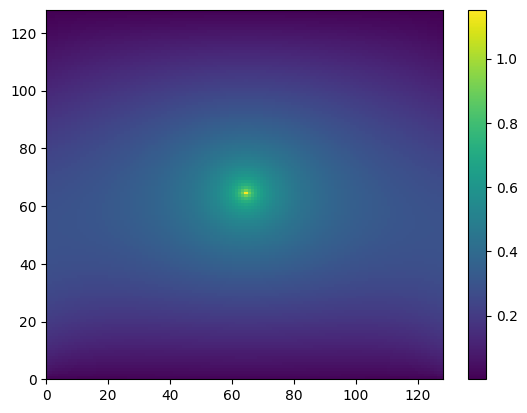

In [35]:
close("all")
pcolormesh(u_host := u_device.copy_to_host()), colorbar()

In [42]:
## SHARED MEMORY EXAMPLE
TPB = 8
TPB2 = TPB + 2
@cuda.jit
def heat2D_shared(u, f, dx2):
  tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
  bx, by = cuda.blockIdx.x, cuda.blockIdx.y
  bwx, bwy = cuda.blockDim.x, cuda.blockDim.y

  i, j = tx + bx*bwx, ty + by*bwy

  # The size has to be known at COMPILATION TIME
  # NOT INITIALISED TO ZERO
  s_u = cuda.shared.array((TPB2, TPB2), dtype=nb.float64)
  i_local = tx + 1
  j_local = ty + 1
  i1 = i + 1
  j1 = j + 1
  if (i < u.shape[1]) and (j < u.shape[0]):
    s_u[j_local, i_local] = u[j1, i1]
    if tx == 0:
      s_u[j_local, i_local - 1] =  u[j1, i1 - 1]
    if ty == 0:
      s_u[j_local - 1, i_local] =  u[j1 - 1, i1]
    if tx == bwx - 1:
      s_u[j_local, i_local + 1] =  u[j1, i1 + 1]
    if ty == bwy - 1:
      s_u[j_local + 1, i_local] =  u[j1 + 1, i1]

  #THERE IS A RACE CONDITION HERE
  cuda.syncthreads()

  if (i < u.shape[1] - 2) and (j < u.shape[0] - 2):
    # YOU CANNOT LOOP UPDATING GLOBAL MEMORY I?NSIDE A KERNEL
      un = s_u[j_local, i_local + 1]
      us = s_u[j_local, i_local - 1]
      uw = s_u[j_local - 1, i_local]
      ue = s_u[j_local + 1, i_local]
      fji = f[j1, i1]
      u[j1, i1] = 0.25*(un + ue + us + uw - dx2[0]*fji)


In [43]:
N = 128
f = zeros((N, N))

u = ones((N, N))
u[0, :] = u[-1, :] = u[:, 0] = u[:, -1] = 0
x = linspace(0, 1, Nx)
dx = x[1] - x[0]
dx2_host = dx**2
f[64, 64] = -1/dx2_host

u_device = cuda.to_device(u)
f_device = cuda.to_device(f)
dx2_device = cuda.to_device([dx2_host]) # You have to create an array of size 1

TPB = 8
for k in range(12000):
  # EVERY TIME YOU MOVE OUTSIDE THE KERNEL, GLOBAL MEMORY IS SYNCHONISED
  heat2D_shared[(N//TPB, N//TPB), (TPB, TPB)](u_device, f_device, dx2_device)

(<matplotlib.collections.QuadMesh at 0x7a4430e30b50>,
 <matplotlib.colorbar.Colorbar at 0x7a4430afe530>)

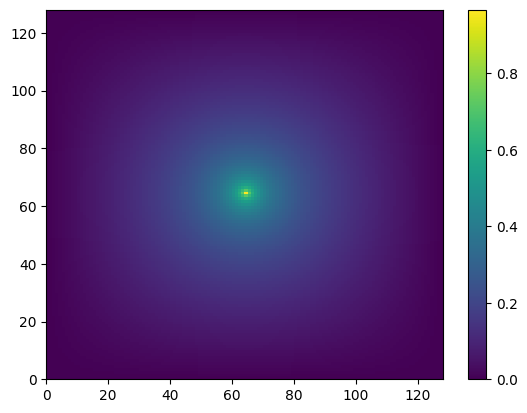

In [44]:
close("all")
pcolormesh(u_host := u_device.copy_to_host()), colorbar()

In [47]:
%time heat2D_shared[(N//TPB, N//TPB), (TPB, TPB)](u_device, f_device, dx2_device)
%time heat2D[(N//TPB, N//TPB), (TPB, TPB)](u_device, f_device, dx2_device)

CPU times: user 672 µs, sys: 34 µs, total: 706 µs
Wall time: 624 µs
CPU times: user 250 µs, sys: 0 ns, total: 250 µs
Wall time: 256 µs


In [62]:
## SHARED MEMORy is only useful if:
## - you have a very clean read (e.g. no ghost points)
## - if you can iterate over those values.

@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    # tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    # bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    # bwx, bwy = cuda.blockDim.x, cuda.blockDim.y

    # i, j = tx + bx*bwx, ty + by*bwy
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        C[i, j] = 0.0
        for k in range(A.shape[1]):
            C[i, j] += A[i, k]*B[k, j]


TPB = 8
@cuda.jit
def fast_matmul(A, B, C):
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=nb.float64)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=nb.float64)

    i, j = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if i < C.shape[0] or j < C.shape[1]:
      tmp = 0.
      for ii in range(bpg):
          sA[tx, ty] = A[i, ty + ii * TPB]
          sB[tx, ty] = B[tx + ii * TPB, j]

          cuda.syncthreads()

          # THE CAKE IS HERE
          for jj in range(TPB):
              tmp += sA[tx, jj] * sB[jj, ty]

          cuda.syncthreads()

      C[i, j] = tmp

In [67]:
N = 2048
TPB = 8
A, B = randn(2, N, N)
C = zeros((N, N))
A_dev, B_dev, C_dev = map(cuda.to_device, (A, B, C))
matmul[(N//TPB, N//TPB), (TPB, TPB)](A_dev, B_dev, C_dev)
C[...] = A@B
norm(C - C_dev.copy_to_host())

1.45891881832766e-10

In [69]:
%time matmul[(N//TPB, N//TPB), (TPB, TPB)](A_dev, B_dev, C_dev)
%time fast_matmul[(N//TPB, N//TPB), (TPB, TPB)](A_dev, B_dev, C_dev)

CPU times: user 0 ns, sys: 800 µs, total: 800 µs
Wall time: 714 µs
CPU times: user 233 µs, sys: 13 µs, total: 246 µs
Wall time: 252 µs


In [70]:
N = 256
x = linspace(-1, 1, N)
X, Y, Z = ix_(x, x, x)
u = exp(-(X**2 + Y**2 + Z**2)*6.28)
dx = x[1] - x[0]
u_dev = cuda.to_device(u)
du_dx_dev = cuda.to_device(zeros((N, N, N)))
du_dX_dev = cuda.to_device(zeros((3, N, N, N)))
dx1_dev = cuda.to_device([1/dx])

In [71]:
#THESE TWO ARE THE SAME (0, 0)
@cuda.jit
def derivative_grid_0(u, du_dx, dx1):
    i, j, k = cuda.grid(3)
    if (k < u.shape[2] - 1) and (j < u.shape[1]) and (i < u.shape[0]):
        du_dx[k, j, i] = dx1[0]*(u[k + 1, j, i] - u[k, j, i])

@cuda.jit
def derivative_loop_0(u, du_dx, dx1): # TRYING TO DO "ENOUGH" OPERATIONS PER THREAD
    i, j = cuda.grid(2)
    if (i < u.shape[1]) and (j < u.shape[0]):
        for k in range(u.shape[0] - 1):
            du_dx[k, j, i] = dx1[0]*(u[k + 1, j, i] - u[k, j, i])

@cuda.jit
def derivative_loop_1(u, du_dx, dx1):
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    bwx, bwy = cuda.blockDim.x, cuda.blockDim.y
    i, j = tx + bx*bwx, ty + by*bwy
    if (i < u.shape[1]) and (j < u.shape[0]):
        for k in range(u.shape[1] - 1):
            du_dx[j, k, i] = dx1[0]*(u[j, k + 1, i] - u[j, k, i])

@cuda.jit
def derivative_loop_2(u, du_dx, dx1): # THIS IS TERREBLY SLOW
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    bwx, bwy = cuda.blockDim.x, cuda.blockDim.y
    i, j = tx + bx*bwx, ty + by*bwy
    if (i < u.shape[1]) and (j < u.shape[0]):
        for k in range(u.shape[2] - 1):
            du_dx[j, i, k] = dx1[0]*(u[j, i, k + 1] - u[j, i, k])


@cuda.jit
def derivative_grid_1(u, du_dx, dx1):
    i, j, k = cuda.grid(3)
    if (k < u.shape[2]) and (j < u.shape[1] - 1) and (i < u.shape[0]):
        du_dx[k, j, i] = dx1[0]*(u[k, j + 1, i] - u[k, j, i])


@cuda.jit
def derivative_grid_2(u, du_dx, dx1): # THIS IS FAST! (COMPILATION MAGIC)
    i, j, k = cuda.grid(3)
    if (k < u.shape[2]) and (j < u.shape[1]) and (i < u.shape[0] - 1):
        du_dx[k, j, i] = dx1[0]*(u[k, j, i + 1] - u[k, j, i])

# TAKE HOME MESSAGE: LITTLE OPERATIONS PER THREAD -> DO IT SIMPLE

@cuda.jit
def derivative_grid_012(u, du_dx, dx1):
    i, j, k = cuda.grid(3)
    if (k < u.shape[2] - 1) and (i < u.shape[1]) and (j < u.shape[0]):
        du_dx[0, k, j, i] = dx1[0]*(u[k + 1, j, i] - u[k, j, i])
    if (k < u.shape[2]) and (j < u.shape[1] - 1) and (i < u.shape[0]):
        du_dx[1, k, j, i] = dx1[0]*(u[k, j + 1, i] - u[k, j, i])
    if (k < u.shape[2]) and (j < u.shape[1]) and (i < u.shape[0] - 1):
        du_dx[2, k, j, i] = dx1[0]*(u[k, j, i + 1] - u[k, j, i])